In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df_sub = pd.read_csv('../data/df_all_subm.csv')
df_com = pd.read_csv('../data/df_all_comm.csv')
df_all = pd.read_csv('../data/df_all_text.csv')

In [40]:
X_sub = df_sub['title']
y_sub = df_sub['is_news']

# split training set and final test set
XS_training, XS_final, yS_training, yS_final = train_test_split(X_sub, y_sub, test_size = 0.1, stratify = y_sub)

# split training set into train/test sets
XS_training.shape, yS_training.shape, XS_final.shape, yS_final.shape

((1456,), (1456,), (162,), (162,))

In [41]:
# repeat for comments df
X_com = df_com['body']
y_com = df_com['is_news']

XC_training, XC_final, yC_training, yC_final = train_test_split(X_com, y_com, test_size = 0.1, stratify = y_com)

XC_training.shape, yC_training.shape, XC_final.shape, yC_final.shape

XC_train, XC_test, yC_train, yC_test = train_test_split(XC_training, yC_training, stratify = yC_training)

In [42]:
XS_train, XS_test, yS_train, yS_test = train_test_split(XS_training, yS_training, stratify = yS_training)

---
## Stacked Model

In [43]:
# stacking highest performing models from 04_nlp_model.ipynb with optimized hyperparameters from Gridsearch

level1_estimators = [
    ('rfc_pipe', Pipeline([
        ('cvec', CountVectorizer(ngram_range = (1,1))),
        ('rfc', RandomForestClassifier(n_estimators = 200))
    ])),
    ('ext_pipe', Pipeline([
        ('cvec', CountVectorizer(ngram_range = (1,1))),
        ('ext', ExtraTreesClassifier())
    ])),
    ('gb_pipe', Pipeline([
        ('cvec', CountVectorizer(ngram_range = (1,2))),
        ('gb', GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 200))
    ]))
]

In [44]:
stacked_model = StackingClassifier(estimators = level1_estimators,
                                   final_estimator = LogisticRegression())

stacked_model.fit(XS_train, yS_train)

StackingClassifier(estimators=[('rfc_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('rfc',
                                                 RandomForestClassifier(n_estimators=200))])),
                               ('ext_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('ext',
                                                 ExtraTreesClassifier())])),
                               ('gb_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(ngram_range=(1,
                                                                              2))),
                                                ('gb',
                                                 GradientBoostingClassifier(learning_rate=0.2,
                                                           

In [45]:
stacked_model.score(XS_train, yS_train), stacked_model.score(XS_test, yS_test), stacked_model.score(XS_final, yS_final)

(1.0, 0.7857142857142857, 0.8580246913580247)

In [9]:
stacked_model.score(XC_train, yC_train), stacked_model.score(XC_test, yC_test), stacked_model.score(XC_final, yC_final)

(0.5441547518923465, 0.5692695214105793, 0.5028248587570622)

In [10]:
stacked_model.estimators_

[Pipeline(steps=[('cvec', CountVectorizer()),
                 ('rfc', RandomForestClassifier(n_estimators=200))]),
 Pipeline(steps=[('cvec', CountVectorizer()), ('ext', ExtraTreesClassifier())]),
 Pipeline(steps=[('cvec', CountVectorizer(ngram_range=(1, 2))),
                 ('gb',
                  GradientBoostingClassifier(learning_rate=0.2,
                                             n_estimators=200))])]

---
## Training the stacked model on ALL (comments + submissions) data

In [31]:
X_a = df_all['text']
y_a = df_all['is_news']

XA_training, XA_final, yA_training, yA_final = train_test_split(X_a, y_a, test_size = 0.1, stratify = y_a)

XA_train, XA_test, yA_train, yA_test = train_test_split(XA_training, yA_training, stratify = yA_training)

In [32]:
stacked_model_A = StackingClassifier(estimators = level1_estimators,
                                   final_estimator = LogisticRegression())

stacked_model_A.fit(XA_train, yA_train)

StackingClassifier(estimators=[('rfc_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('rfc',
                                                 RandomForestClassifier(n_estimators=200))])),
                               ('ext_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('ext',
                                                 ExtraTreesClassifier())])),
                               ('gb_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(ngram_range=(1,
                                                                              2))),
                                                ('gb',
                                                 GradientBoostingClassifier(learning_rate=0.2,
                                                           

In [33]:
stacked_model_A.score(XA_train, yA_train), stacked_model_A.score(XA_test, yA_test), stacked_model_A.score(XA_final, yA_final)

(0.9995615957913196, 0.7687253613666228, 0.7463126843657817)

In [34]:
stacked_model_A.score(XS_train, yS_train), stacked_model_A.score(XS_test, yS_test), stacked_model_A.score(XS_final, yS_final)

(0.9358974358974359, 0.9203296703296703, 0.9259259259259259)

In [35]:
stacked_model_A.score(XC_train, yC_train), stacked_model_A.score(XC_test, yC_test), stacked_model_A.score(XC_final, yC_final)

(0.9074852817493693, 0.9345088161209067, 0.9152542372881356)

---

In [46]:
stacked_preds = stacked_model.predict(XS_final)

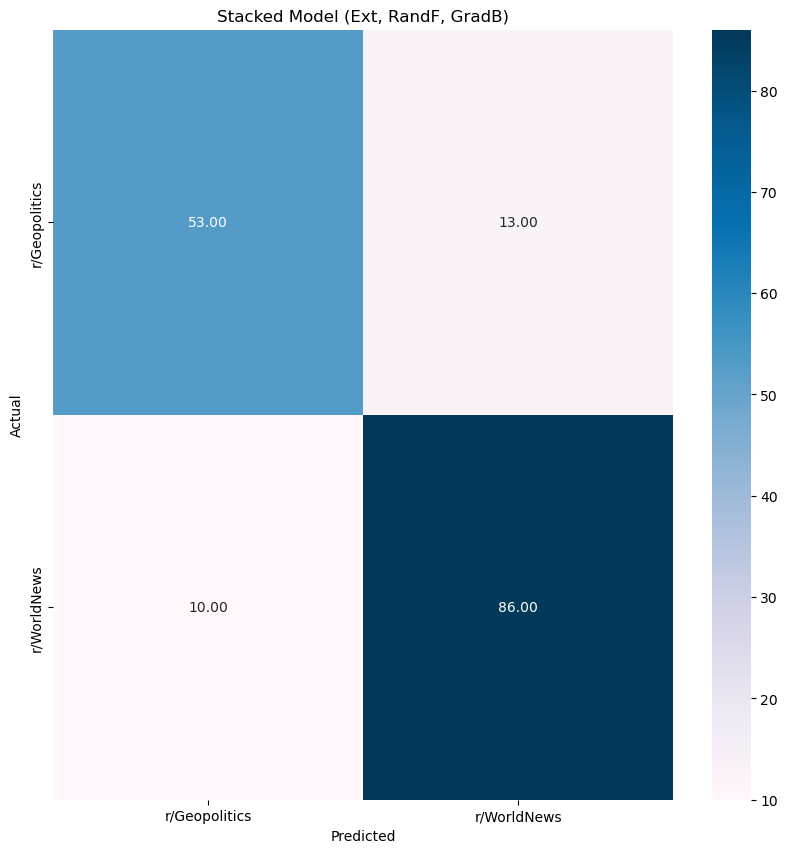

In [49]:
cm = confusion_matrix(stacked_preds, yS_final)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['r/Geopolitics', 'r/WorldNews'],
            yticklabels = ['r/Geopolitics', 'r/WorldNews'], cmap = 'PuBu')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Stacked Model (Ext, RandF, GradB)')
# plt.show(block=False)

plt.savefig('../visuals/stacked_cm.png')

In [49]:
df_analysis = df_sub.loc[yS_final.index]

In [50]:
df_analysis['preds'] = stacked_preds

In [54]:
df_analysis.to_csv('../data/df_analysis.csv', index = False)